# Introduction

This is the final project for MScA 32018 Natural Language Processing. 

## Prompt

Illinois is famous for being one of the very few states in the country with negative population growth.  The objective of your final project is to:

1. Identify the key reasons for the declining population by extracting meaningful insights from unstructured text
2. Provide actionable recommendations on what can be done to reverse this trend


## Approach

From the list of news articles provided, first try to assign a broadly positive, negative, or neutral sentiment to each article. Within each of these sentiment groups, do some topic modeling to identify major trends of positive and negative behaviors within the City/State. The final deck will suggest to reduce or minimize negative trends will highlighting or focusing on positive trends.


# Setup

## Packages

In [1]:
# Base
import os
import re
import string

# Data Structures
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NLP
from textblob import TextBlob
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Sentiment
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Topic Modeling
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis

## Data Cleaning

In [2]:
df = pd.read_pickle(os.path.expanduser('~/Datasets/32018/news_chicago_il.pkl'))
df.head()

,crawled,language,text,title
0,2019-04-27T23:25:33.038+03:00,english,"With their second pick in the draft, in Round ...",Family affair: Bears fourth-round WR Riley Rid...
1,2019-04-27T23:27:06.000+03:00,english,From an article at the Chicago Tribune by Cont...,Coin Flip Determines Winner Of Election In Chi...
2,2019-04-27T23:28:26.072+03:00,english,Fill in your details below or click an icon to...,FOX NEWS: Late April storm dumps snow across M...
3,2019-04-27T23:29:54.002+03:00,english,Chicago Police Supt. Eddie Johnson (AP Photo/T...,Chicago Police Department ‘Fixes’ Their FOID R...
4,2019-04-27T23:30:02.083+03:00,english,Comment If the Chicago Bulls are willing to ge...,Chicago Bulls: 76ers Tobias Harris free agency...


In [3]:
df.text[0]

'With their second pick in the draft, in Round 4 at No. 126 overall, the Bears selected Georgia WR Riley Ridley , the little brother of Atlanta Falcons 2018 first-round All-Rookie WR Calvin .\nRidley (6-foot-1, 199 pounds) caught a team-high 44 balls for 570 yards and nine touchdowns as a true junior last year, his first as'

In [4]:
df['title'] = df['title'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))
df['text']   = df['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

# Sentiment

## Afinn

In [5]:
afinn = Afinn(language='en')

In [6]:
print(df.title[0])
print(afinn.score(df.title[0]))
print()
print(df.text[0])
print(afinn.score(df.text[0]))

Family affair: Bears fourthround WR Riley Ridley feeling the love from Chicago
4.0

With their second pick in the draft, in Round 4 at No. 126 overall, the Bears selected Georgia WR Riley Ridley , the little brother of Atlanta Falcons 2018 firstround AllRookie WR Calvin .Ridley 6foot1, 199 pounds caught a teamhigh 44 balls for 570 yards and nine touchdowns as a true junior last year, his first as
1.0


In [7]:
print(df.title[3732])
print(afinn.score(df.title[3732]))
print()
print(df.text[3732])
print(afinn.score(df.text[3732]))

Driver charged in fiery crash that left Uber passenger dead in Chicago  News Headlines  kmov.com
-8.0

SaveCHICAGO, IL KMOV.com  The Illinois State Police have arrested a 23yearold Chicago man who allegedly fled the scene of a fatal fiery crash overnight Sunday.According to police, Rami Matariyeh, 23, was driving down southbound Interstate 55 at Damen Avenue when it rearended an Uber car with passengers inside.The car then burst into flames after the impact, officials say.Three people were able to escape to safety expect for a woman, later identified as Jamie Poulos, who was in the back seat. Police said Matariyeh left the scene of crash but the passenger riding in his car remain on scene.All the passengers in the Uber car and the passenger in the suspects car were injured following the crash and taken to a hospital by emergency crews.Matariyeh was later arrested at his home and transported to a local hospital for his injuries.He was charged with aggravated DUI death, aggravated DUI, l

In [8]:
print(df.title[7518])
print(afinn.score(df.title[7518]))
print()
print(df.text[7518])
print(afinn.score(df.text[7518]))

Illinois governor announces plan to legalize marijuana
0.0

War on drugs Illinois governor announces plan to legalize marijuana This is a political forum that is nonbiasednonpartisan and treats every persons position on topics equally. This debate forum is not aligned to any political party. In todays politics , many ideas are split between and even within all the political parties. Often we find ourselves agreeing on one platform but some topics break our mold. We are here to discuss them in a civil political debate. If this is your first visit to our political forums, be sure to check out the FAQ and RULES . Registering for debate politics is necessary before posting. Register today to participate and remove the ads  its free Results 1 to 4 of 4
-1.0


In [9]:
def word_count(text_string):
    '''Calculate the number of words in a string'''
    return len(text_string.split())

In [10]:
# This cell takes a long time

df['afinn_score_title'] = df.title.apply(afinn.score)
df['afinn_score_text'] = df.text.apply(afinn.score)

df['word_count_title'] = df.title.apply(word_count)
df['word_count_text'] = df.text.apply(word_count)

df['afinn_adjusted_title'] = df.afinn_score_title / df.word_count_title * 100
df['afinn_adjusted_text'] = df.afinn_score_text / df.word_count_text * 100

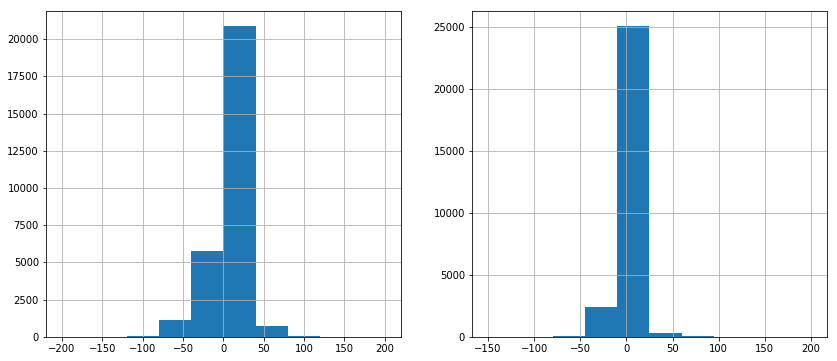

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

df.afinn_adjusted_title.hist(ax=axes[0])
df.afinn_adjusted_text.hist(ax=axes[1])

In [12]:
df[df['afinn_adjusted_title'] > 10].afinn_adjusted_title.describe()

count    4478.000000
mean       26.866629
std        15.416118
min        10.204082
25%        15.384615
50%        22.222222
75%        33.333333
max       200.000000
Name: afinn_adjusted_title, dtype: float64

## Vader

In [13]:
analyzer = SentimentIntensityAnalyzer()

In [14]:
def vader_sentiment(score):
    if score > 0.25:
        return('pos')
    elif score < -0.25:
        return('neg')
    else:
        return('net')

In [15]:
print(df.title[0])
print(analyzer.polarity_scores(df.title[0]))
print()
print(df.title[3732])
print(analyzer.polarity_scores(df.title[3732]))
print()
print(df.title[7518])
print(analyzer.polarity_scores(df.title[7518]))

Family affair: Bears fourthround WR Riley Ridley feeling the love from Chicago
{'neg': 0.0, 'neu': 0.637, 'pos': 0.363, 'compound': 0.6908}

Driver charged in fiery crash that left Uber passenger dead in Chicago  News Headlines  kmov.com
{'neg': 0.511, 'neu': 0.489, 'pos': 0.0, 'compound': -0.888}

Illinois governor announces plan to legalize marijuana
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [16]:
df['vader_score_title'] = df.title.apply(lambda x: analyzer.polarity_scores(x)['compound'])
#df['vader_score_text'] = df.text.apply(lambda x: analyzer.polarity_scores(x)['compound'])

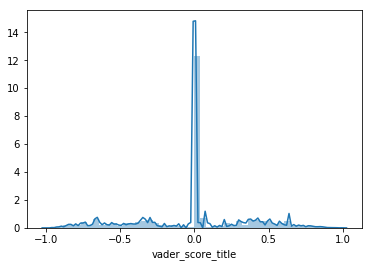

In [17]:
sns.distplot(df.vader_score_title)

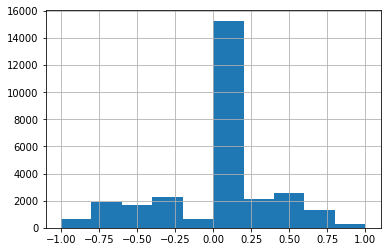

In [18]:
df.vader_score_title.hist()

In [19]:
df['vader_sentiment_title'] = df.vader_score_title.apply(vader_sentiment)

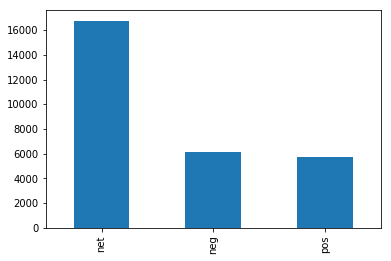

In [20]:
df.vader_sentiment_title.value_counts().plot.bar()

Okay so the sentinment found by the Afinn and the Vader methods are strongly similar.

0.7603560161637024


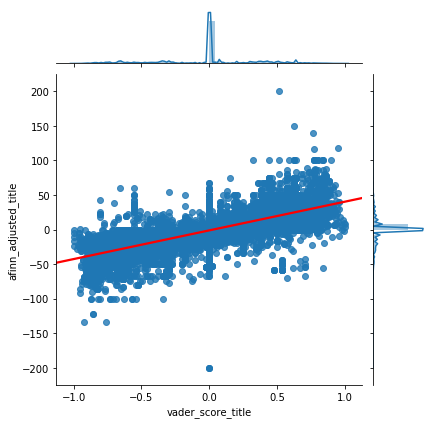

In [21]:
sns.jointplot(data=df, x='vader_score_title', y='afinn_adjusted_title', 
              kind='reg', joint_kws={'line_kws':{'color':'red'}})

print(df.vader_score_title.corr(df.afinn_adjusted_title))

In [22]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(df[['vader_score_title']], df['afinn_adjusted_title'])

reg.score(df[['vader_score_title']], df['afinn_adjusted_title'])

0.5781412713163394

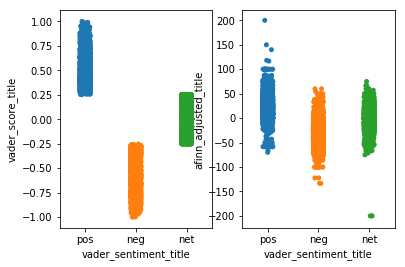

In [23]:
fig, axes = plt.subplots(ncols=2)
sns.catplot(x='vader_sentiment_title', y='vader_score_title', data=df, ax=axes[0])
sns.catplot(x='vader_sentiment_title', y='afinn_adjusted_title', data=df, ax=axes[1])
plt.close(2)
plt.close(3)

# Topic Modeling

In [24]:
stop = set(stopwords.words('english'))
for w in ['chicago', 'illinois', 'said', 'state', 'may', 'get']:
    stop.add(w)

exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

df['title_clean'] = [clean(doc).split() for doc in df.text.to_list()]
df['text_clean'] = [clean(doc).split() for doc in df.text.to_list()]

In [25]:
pos = df[df.vader_sentiment_title == 'pos']
neg = df[df.vader_sentiment_title == 'neg']

print(df.shape)
print(pos.shape)
print(neg.shape)

(28604, 14)
(5696, 14)
(6165, 14)


In [26]:
pos_title_dict = corpora.Dictionary(pos['title_clean'])
pos_text_dict  = corpora.Dictionary(neg['text_clean'])

neg_title_dict = corpora.Dictionary(pos['title_clean'])
neg_text_dict  = corpora.Dictionary(neg['text_clean'])

In [27]:
%time pos_title_doc_term_matrix = [pos_title_dict.doc2bow(doc) for doc in pos.title_clean]
%time neg_title_doc_term_matrix = [neg_title_dict.doc2bow(doc) for doc in neg.title_clean]

CPU times: user 1.24 s, sys: 51.3 ms, total: 1.29 s
Wall time: 1.32 s
CPU times: user 1.14 s, sys: 45.1 ms, total: 1.18 s
Wall time: 1.24 s


In [28]:
max_topics = 10
n_topics = []

pos_title_lda_models = []
neg_title_lda_models = []

for i in range(1, max_topics):
    n_topics.append(i+1)
    %time pos_title_model = LdaMulticore(pos_title_doc_term_matrix, num_topics=i+1, id2word = pos_title_dict, passes=10)
    %time neg_title_model = LdaMulticore(neg_title_doc_term_matrix, num_topics=i+1, id2word = neg_title_dict, passes=10)
    pos_title_lda_models.append(pos_title_model)
    neg_title_lda_models.append(neg_title_model)

CPU times: user 52.4 s, sys: 4.43 s, total: 56.8 s
Wall time: 1min 8s
CPU times: user 27.9 s, sys: 4.09 s, total: 32 s
Wall time: 39.9 s
CPU times: user 51.5 s, sys: 4.47 s, total: 56 s
Wall time: 1min 4s
CPU times: user 28 s, sys: 4.17 s, total: 32.2 s
Wall time: 40 s
CPU times: user 51.9 s, sys: 4.58 s, total: 56.5 s
Wall time: 1min 4s
CPU times: user 28.4 s, sys: 4.27 s, total: 32.7 s
Wall time: 39.7 s
CPU times: user 51.5 s, sys: 4.6 s, total: 56.1 s
Wall time: 1min 4s
CPU times: user 29.2 s, sys: 4.43 s, total: 33.7 s
Wall time: 42.3 s
CPU times: user 51.6 s, sys: 4.69 s, total: 56.3 s
Wall time: 1min 4s
CPU times: user 28.7 s, sys: 4.37 s, total: 33.1 s
Wall time: 40.4 s
CPU times: user 53.1 s, sys: 4.85 s, total: 57.9 s
Wall time: 1min 6s
CPU times: user 30.4 s, sys: 4.79 s, total: 35.2 s
Wall time: 43.1 s
CPU times: user 53 s, sys: 4.93 s, total: 58 s
Wall time: 1min 6s
CPU times: user 27.7 s, sys: 4.41 s, total: 32.1 s
Wall time: 40 s
CPU times: user 54.1 s, sys: 5.13 s, total

In [29]:
pos_title_coherence_scores = []
neg_title_coherence_scores = []

for model in pos_title_lda_models:
    coherencemodel = CoherenceModel(model=model, texts=pos.title_clean, dictionary=pos_title_dict, coherence='c_v')
    pos_title_coherence_scores.append(coherencemodel.get_coherence())
    
for model in neg_title_lda_models:
    coherencemodel = CoherenceModel(model=model, texts=neg.title_clean, dictionary=neg_title_dict, coherence='c_v')
    neg_title_coherence_scores.append(coherencemodel.get_coherence())

[Text(0, 0.5, 'Negative Title Coherence Score'),
 Text(0.5, 0, 'Number of Topics')]

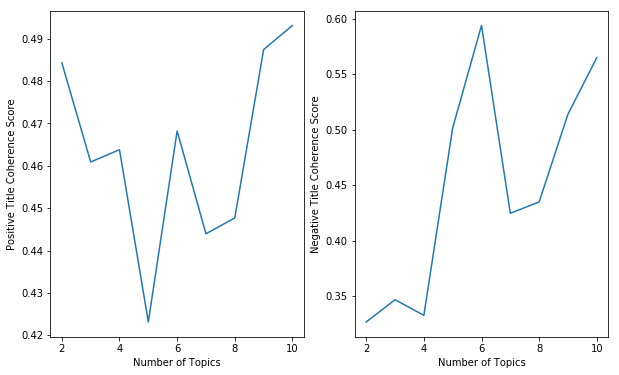

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(10,6))

sns.lineplot(x=n_topics, y=pos_title_coherence_scores, ax=axes[0])
axes[0].set(xlabel='Number of Topics', ylabel='Positive Title Coherence Score')

sns.lineplot(x=n_topics, y=neg_title_coherence_scores, ax=axes[1])
axes[1].set(xlabel='Number of Topics', ylabel='Negative Title Coherence Score')

In [34]:
pd.DataFrame({'NumTopics':n_topics, 
              'neg_coherence': neg_title_coherence_scores, 
              'pos_coherence': pos_title_coherence_scores})

,NumTopics,neg_coherence,pos_coherence
0,2,0.326780,0.484314
1,3,0.346840,0.460908
2,4,0.332723,0.463813
3,5,0.501590,0.423138
4,6,0.593861,0.468223
5,7,0.424687,0.443952
6,8,0.434881,0.447702
7,9,0.514013,0.487444
8,10,0.564919,0.493138


In [36]:
pos_title_lda_models[4-2].print_topics()

[(0,
  '0.008*"credit" + 0.007*"service" + 0.006*"counseling" + 0.004*"company" + 0.004*"tax" + 0.004*"need" + 0.004*"also" + 0.003*"one" + 0.003*"program" + 0.003*"2019"'),
 (1,
  '0.005*"game" + 0.005*"2019" + 0.004*"year" + 0.004*"one" + 0.004*"last" + 0.004*"first" + 0.003*"season" + 0.003*"team" + 0.003*"two" + 0.003*"work"'),
 (2,
  '0.004*"year" + 0.004*"job" + 0.004*"new" + 0.004*"one" + 0.004*"experience" + 0.003*"time" + 0.003*"customer" + 0.003*"chicago" + 0.003*"day" + 0.003*"city"'),
 (3,
  '0.023*"share" + 0.018*"tool" + 0.017*"work" + 0.017*"company" + 0.015*"stock" + 0.012*"rating" + 0.012*"quarter" + 0.008*"inc" + 0.007*"product" + 0.007*"price"')]

In [37]:
neg_title_lda_models[6-2].print_topics()

[(0,
  '0.007*"police" + 0.007*"jaylon" + 0.006*"said" + 0.006*"news" + 0.005*"party" + 0.005*"shot" + 0.005*"year" + 0.004*"star" + 0.004*"saturday" + 0.004*"time"'),
 (1,
  '0.005*"game" + 0.005*"one" + 0.004*"time" + 0.004*"fire" + 0.004*"daoud" + 0.004*"first" + 0.003*"season" + 0.003*"2019" + 0.003*"cub" + 0.003*"two"'),
 (2,
  '0.014*"baby" + 0.011*"figueroa" + 0.009*"2019" + 0.007*"clarisa" + 0.007*"say" + 0.006*"police" + 0.006*"teen" + 0.005*"charged" + 0.005*"murder" + 0.005*"womb"'),
 (3,
  '0.021*"baby" + 0.014*"police" + 0.012*"woman" + 0.011*"figueroa" + 0.010*"family" + 0.009*"home" + 0.009*"ochoalopez" + 0.008*"mother" + 0.007*"pregnant" + 0.007*"found"'),
 (4,
  '0.017*"explosion" + 0.013*"fire" + 0.012*"plant" + 0.009*"silicone" + 0.009*"police" + 0.008*"lenzi" + 0.008*"two" + 0.008*"waukegan" + 0.008*"said" + 0.008*"body"'),
 (5,
  '0.005*"city" + 0.005*"year" + 0.004*"child" + 0.004*"case" + 0.004*"also" + 0.004*"new" + 0.004*"2019" + 0.004*"state" + 0.003*"would" +

In [40]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(pos_title_lda_models[4-2], pos_title_doc_term_matrix, pos_title_dict, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
